In [4]:
data_dict = catalog.load('center_out_hdf5')
spectrogram_dict = catalog.load("center_out_spectrogram_std_pkl")
curated_states_partition = catalog.load("center_out_curated_states_pkl")

[11/29/22 23:12:43] INFO     Loading data from 'center_out_hdf5' (PartitionedDataSet)...        ]8;id=722998;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=478265;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'center_out_spectrogram_std_pkl'                 ]8;id=462440;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=235175;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'center_out_curated_states_pkl'                  ]8;id=657946;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=21207;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

In [5]:
total_sxx = 0



In [6]:
patient_id = context.params['patient_id']
sessions = context.params['sessions']
spectrogram_params = context.params['spectrogram_params']
current_experiment = context.params['current_experiment']

mean_dict_total = {}
for session_type, session_data in sessions[patient_id][current_experiment].items():
    total_length_dict = {}
    for curated_states_key, curated_states_data_func in curated_states_partition.items():
        date = curated_states_key.split('_')[-2]
        session = curated_states_key.split('_')[-1]
        
        if date in session_data.keys() and session in session_data[date]:
            curated_states_dict = curated_states_data_func()

            for state, state_information in curated_states_dict.items():
                cur_count = total_length_dict.setdefault(state, 0)
                cur_count += len(state_information['start_end_idx'])
                total_length_dict[state] = cur_count

In [7]:
total_length_dict

{0: 312, 1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 7: 40, 8: 40}

In [46]:
import numpy as np

patient_id = context.params['patient_id']
sessions = context.params['sessions']
spectrogram_params = context.params['spectrogram_params']
current_experiment = context.params['current_experiment']


pre_stimulus_time = 0.3
post_stimulus_time = 2

def generate_mean_sxx_dict(spectrogram_dict, curated_states_partition, sessions, patient_id, spectrogram_params, current_experiment)

    shift = spectrogram_params['shift']
    pre_stimulus_time = spectrogram_params['pre_stimulus_time']
    post_stimulus_time = spectrogram_params['post_st']

    mean_dict_total = {}
    for session_type, session_data in sessions[patient_id][current_experiment].items():
        total_length_dict = {}
        for curated_states_key, curated_states_data_func in curated_states_partition.items():
            date = curated_states_key.split('_')[-2]
            session = curated_states_key.split('_')[-1]

            if date in session_data.keys() and session in session_data[date]:
                curated_states_dict = curated_states_data_func()

                for state, state_information in curated_states_dict.items():
                    cur_count = total_length_dict.setdefault(state, 0)
                    cur_count += len(state_information['start_end_idx'])
                    total_length_dict[state] = cur_count

        mean_dicts = {}
        for sxx_partition_key, sxx_partition_func in spectrogram_dict.items():
            date = sxx_partition_key.split('_')[-2]
            session = sxx_partition_key.split('_')[-1]

            if date in session_data.keys() and session in session_data[date]:
                curated_states_data_func = curated_states_partition[sxx_partition_key]
                curated_states_dict = curated_states_data_func()
                sxx_data_dict = sxx_partition_func()

                sampling_rate = sxx_data_dict['sampling_rate']

                samples_pre = int(np.ceil((pre_stimulus_time * sampling_rate)/shift))
                samples_post = int(np.ceil((post_stimulus_time * sampling_rate)/shift))
                t_sample = np.arange(-(samples_pre * shift)/sampling_rate, ((samples_post + 1) * shift)/sampling_rate, shift/sampling_rate)
                f_sxx = sxx_data_dict['f']

                avg_sxx_states_dict = {}
                for state, state_information in curated_states_dict.items():
                    cur_dict = {}

                    start_end_idx = state_information['start_end_idx']
                    cur_dict['start_end_idx'] = [(x[0]-samples_pre, x[0]+samples_post) for x in start_end_idx]
                    cur_dict['unique_val_idx'] = [np.arange(x[0], x[1]+1) for x in cur_dict['start_end_idx']]
                    cur_dict['num_steps'] = [len(x) for x in cur_dict['unique_val_idx']]

                    avg_sxx_states_dict[state] = cur_dict
                    avg_sxx_states_dict[state]['length'] = len(state_information['num_steps'])


                sxx = sxx_data_dict['sxx']

                for state, recalculated_state_information in avg_sxx_states_dict.items():
                    cur_mean = mean_dicts.setdefault(state, {'mean_sxx': 0, 't': t_sample, 'f': f_sxx})

                    mean_sxx_direction = np.mean(np.array(([sxx[:, idx_array, :] for idx_array in avg_sxx_states_dict[state]['unique_val_idx']])), axis = 0)
                    mean_sxx_direction *= (avg_sxx_states_dict[state]['length']/total_length_dict[state])

                    cur_mean['mean_sxx'] += mean_sxx_direction

                    mean_dicts[state] = cur_mean

        mean_dict_total[session_type] = mean_dicts
    return mean_dict_total

In [44]:
mean_dict_total['overt'][1]['t']

array([-3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
       -1.00000000e-01, -5.00000000e-02, -5.55111512e-17,  5.00000000e-02,
        1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
        3.00000000e-01,  3.50000000e-01,  4.00000000e-01,  4.50000000e-01,
        5.00000000e-01,  5.50000000e-01,  6.00000000e-01,  6.50000000e-01,
        7.00000000e-01,  7.50000000e-01,  8.00000000e-01,  8.50000000e-01,
        9.00000000e-01,  9.50000000e-01,  1.00000000e+00,  1.05000000e+00,
        1.10000000e+00,  1.15000000e+00,  1.20000000e+00,  1.25000000e+00,
        1.30000000e+00,  1.35000000e+00,  1.40000000e+00,  1.45000000e+00,
        1.50000000e+00,  1.55000000e+00,  1.60000000e+00,  1.65000000e+00,
        1.70000000e+00,  1.75000000e+00,  1.80000000e+00,  1.85000000e+00,
        1.90000000e+00,  1.95000000e+00,  2.00000000e+00])

In [36]:
np.arange(-(samples_pre * shift)/sampling_rate, ((samples_post + 1) * shift)/sampling_rate, shift/sampling_rate)

array([-3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
       -1.00000000e-01, -5.00000000e-02, -5.55111512e-17,  5.00000000e-02,
        1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
        3.00000000e-01,  3.50000000e-01,  4.00000000e-01,  4.50000000e-01,
        5.00000000e-01,  5.50000000e-01,  6.00000000e-01,  6.50000000e-01,
        7.00000000e-01,  7.50000000e-01,  8.00000000e-01,  8.50000000e-01,
        9.00000000e-01,  9.50000000e-01,  1.00000000e+00,  1.05000000e+00,
        1.10000000e+00,  1.15000000e+00,  1.20000000e+00,  1.25000000e+00,
        1.30000000e+00,  1.35000000e+00,  1.40000000e+00,  1.45000000e+00,
        1.50000000e+00,  1.55000000e+00,  1.60000000e+00,  1.65000000e+00,
        1.70000000e+00,  1.75000000e+00,  1.80000000e+00,  1.85000000e+00,
        1.90000000e+00,  1.95000000e+00,  2.00000000e+00])

In [27]:
sxx_data_dict['t'][avg_sxx_states_dict[state]['unique_val_idx'][0]]

array([27.206, 27.256, 27.306, 27.356, 27.406, 27.456, 27.506, 27.556,
       27.606, 27.656, 27.706, 27.756, 27.806, 27.856, 27.906, 27.956,
       28.006, 28.056, 28.106, 28.156, 28.206, 28.256, 28.306, 28.356,
       28.406, 28.456, 28.506, 28.556, 28.606, 28.656, 28.706, 28.756,
       28.806, 28.856, 28.906, 28.956, 29.006, 29.056, 29.106, 29.156,
       29.206, 29.256, 29.306, 29.356, 29.406, 29.456, 29.506])

In [69]:
grid_layout = context.params['grid_layout'][patient_id]

plot_sxx_params = context.params['plot_sxx_params']

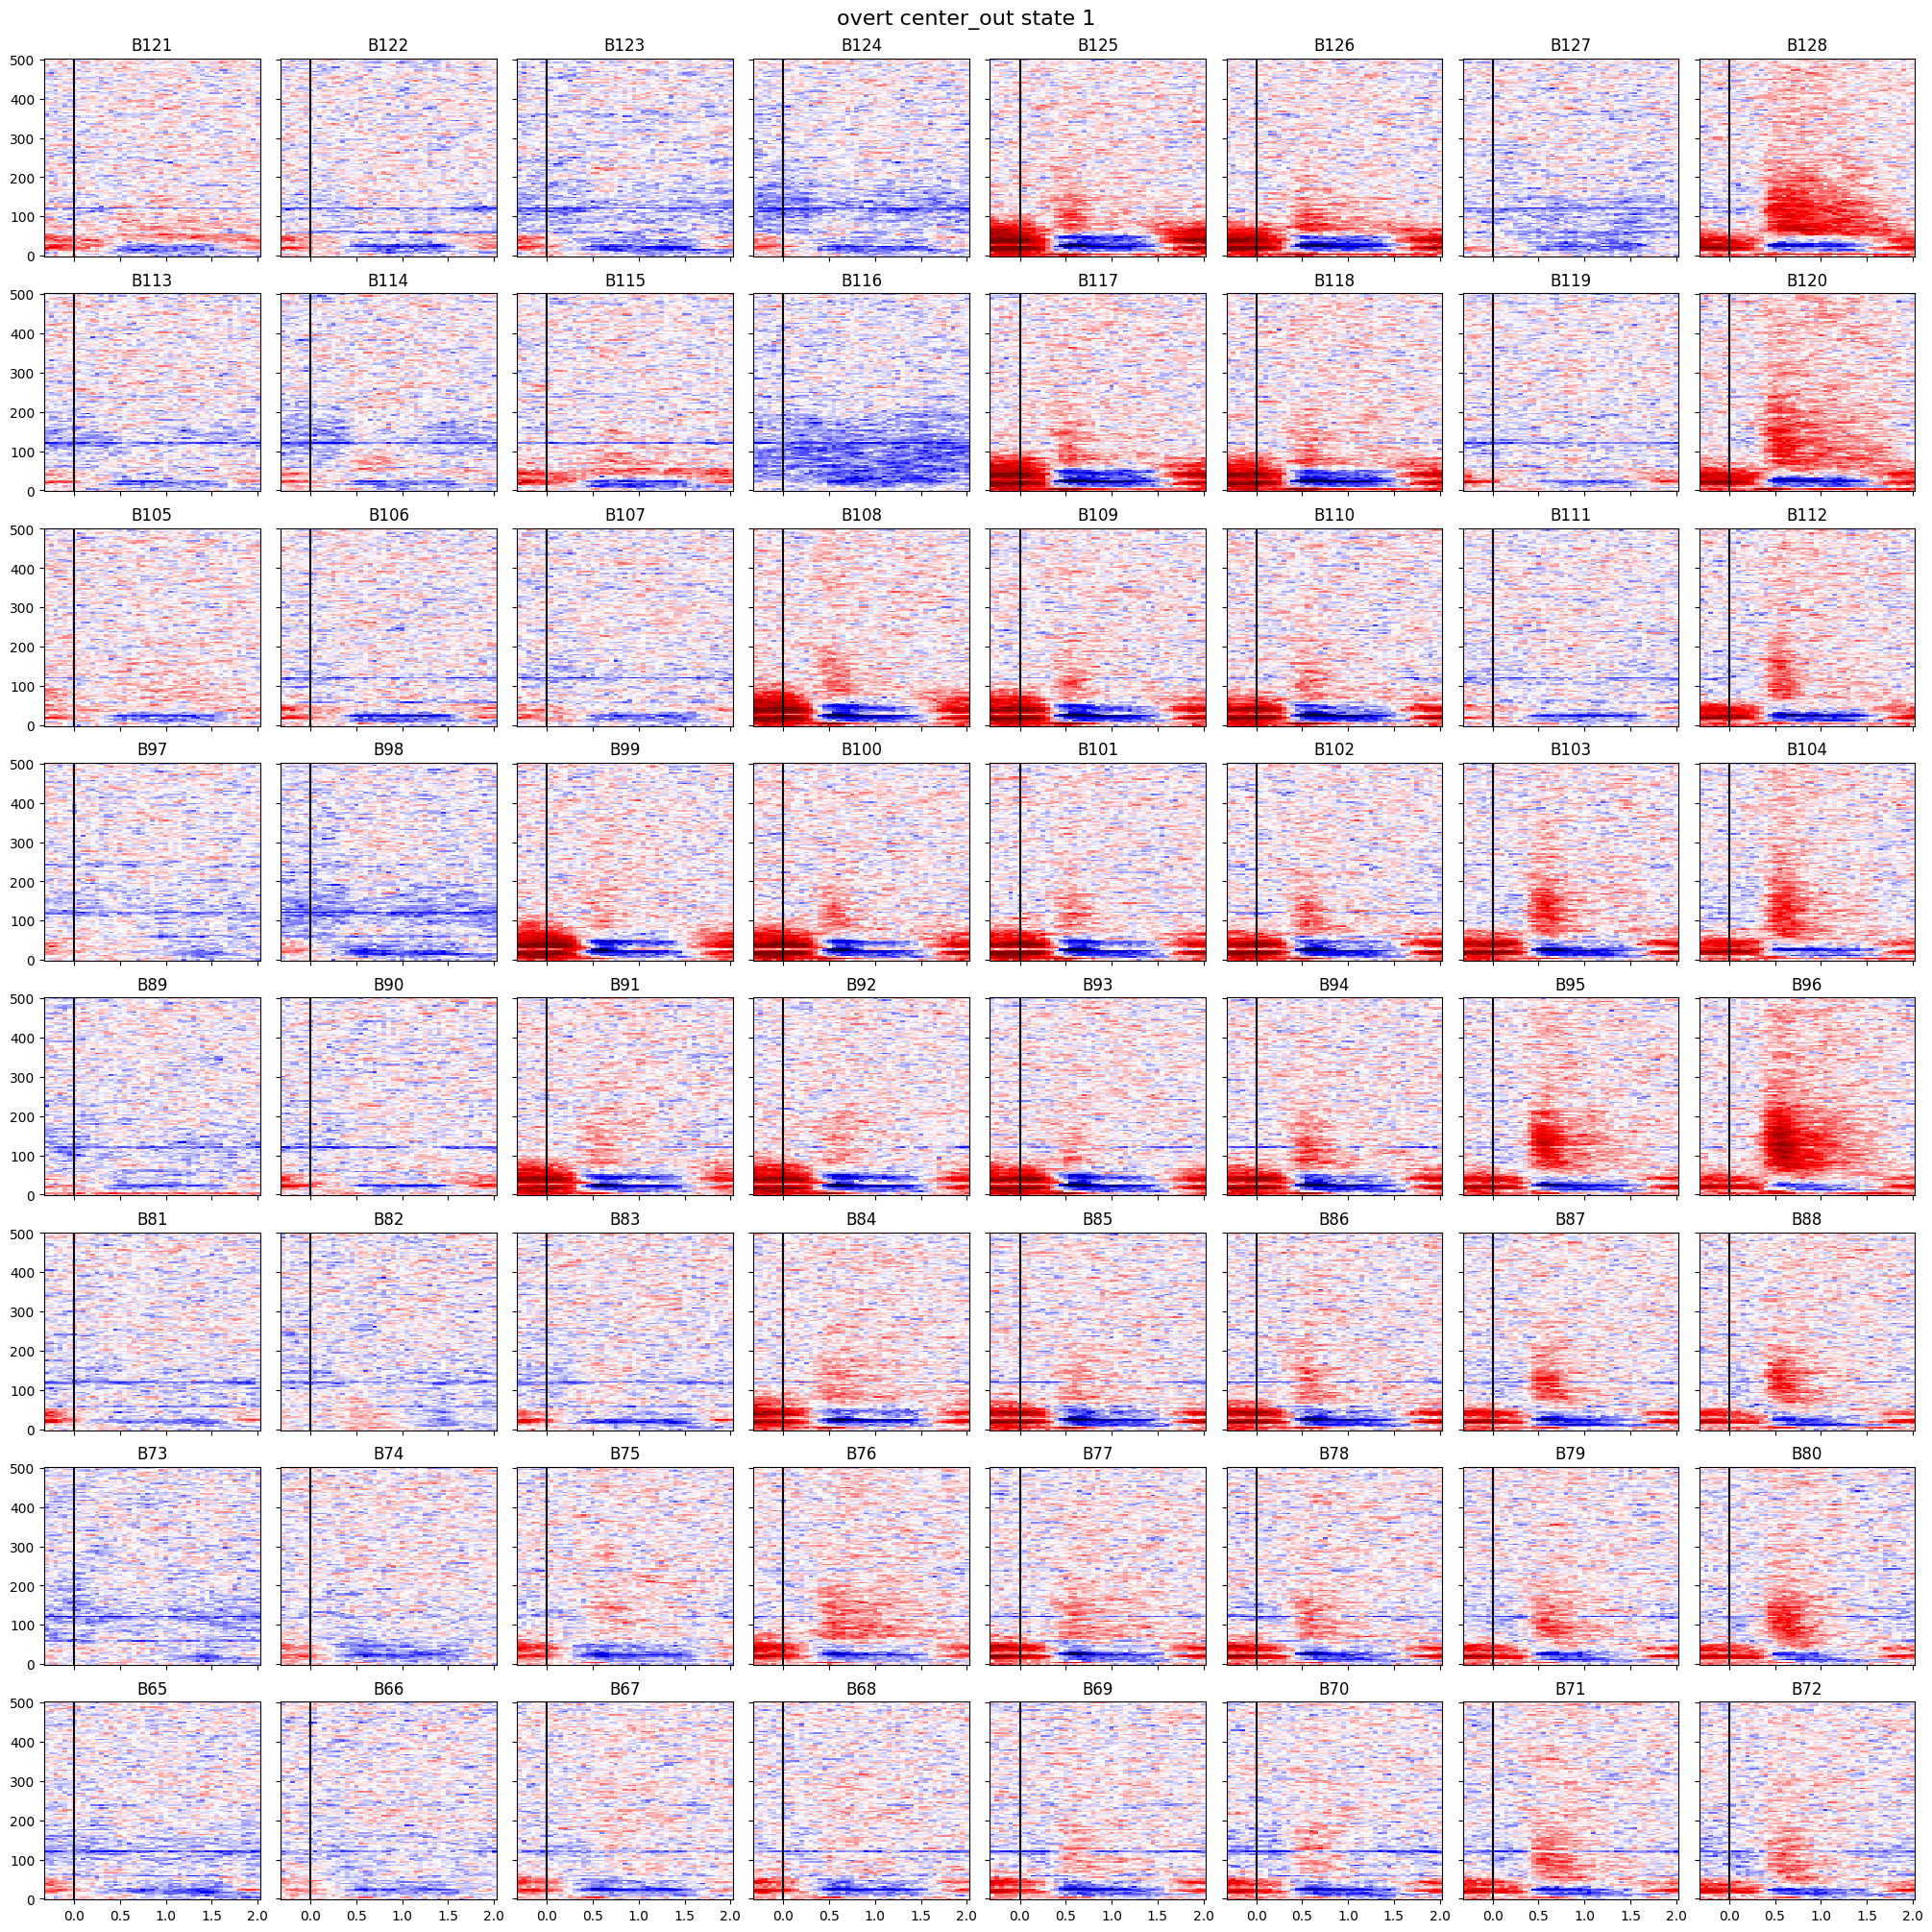

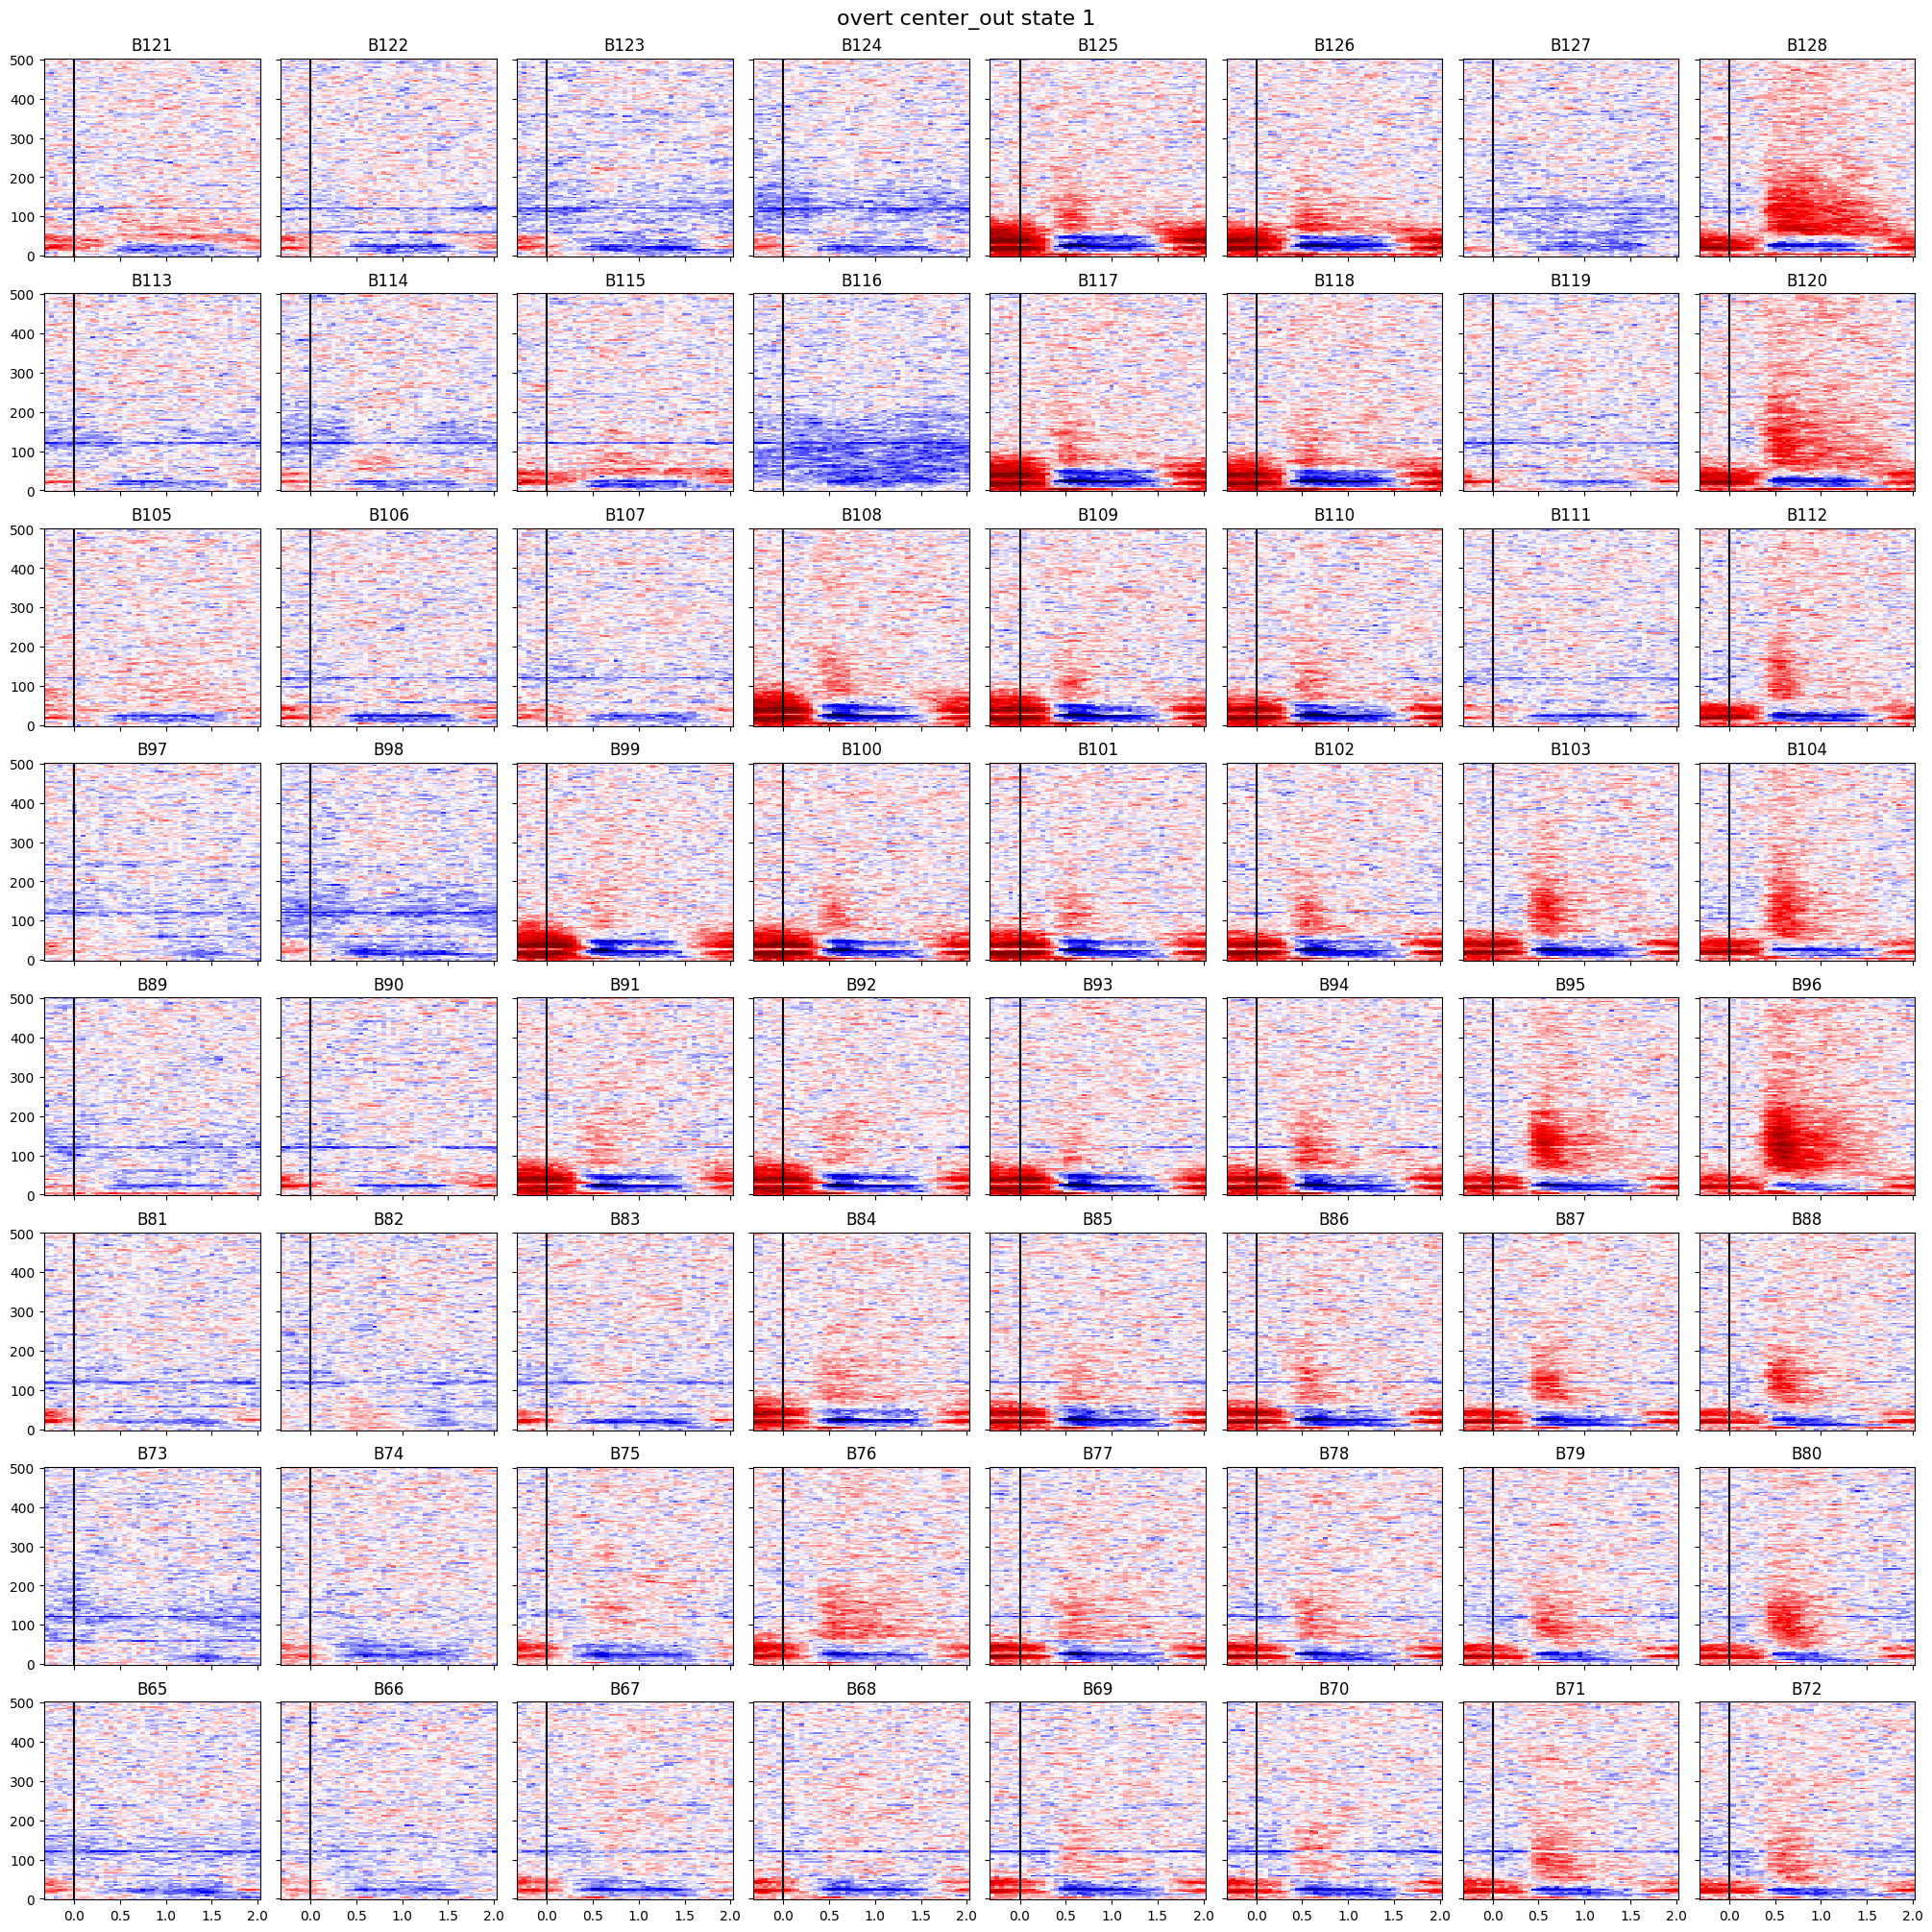

In [72]:
_plot_average_sxx('center_out', 'overt', 1, mean_dict_total['overt'][1], 'B', ch_suffix_order, plot_sxx_params, grid_layout)

In [71]:
import matplotlib.pyplot as plt

task_paradigm = 'overt'
state = 1

prefixed_channels = catalog.load('prefixed_channels')

ch_suffix_order = prefixed_channels['ch_suffix_order']

ch_suffix_key = list(ch_suffix_order.keys())[1]

def _plot_average_sxx(current_experiment, task_paradigm, state, sxx_data, ch_suffix_key, ch_suffix_order, plot_sxx_params, grid_layout):

    cur_mean_sxx = sxx_data['mean_sxx']
    t_samples = sxx_data['t']
    f_samples = sxx_data['f']
    
    fig_width = plot_sxx_params['fig_width']
    fig_height = plot_sxx_params['fig_height']
    sharex = plot_sxx_params['sharex']
    sharey = plot_sxx_params['sharey']
    vmin = plot_sxx_params['vmin']
    vmax = plot_sxx_params['vmax']
    
    sel_grid = None
    sel_suffix_key = None
    for cur_grid in grid_layout:
        if np.array(cur_grid).flatten()[0][0] == ch_suffix_key:
            sel_suffix_key = ch_suffix_key
            sel_grid = np.array(cur_grid)
            break

    sel_ch_suffix_order = ch_suffix_order[sel_suffix_key]

    grid_rows = sel_grid.shape[0]
    grid_cols = sel_grid.shape[1]
    fig, axs  = plt.subplots(grid_rows, grid_cols, figsize = (fig_width, fig_height), sharex=sharex, sharey=sharey, constrained_layout=True);

    ch_ind = 0
    for ch in sel_ch_suffix_order:
        row = np.where(sel_grid == ch)[0][0]
        col = np.where(sel_grid == ch)[1][0]

        if grid_rows == 1:
            im = axs[col].pcolormesh(t_samples, f_samples, cur_mean_sxx[:,:,ch_ind], cmap = 'seismic', vmin = vmin, vmax = vmax);
            axs[col].set_title(ch)
            axs[col].axvline(x=0, color = 'k')

        elif grid_cols == 1:
            im = axs[row].pcolormesh(t_samples, f_samples, cur_mean_sxx[:,:,ch_ind], cmap = 'seismic', vmin = vmin, vmax = vmax);
            axs[row].set_title(ch)
            axs[row].axvline(x=0, color = 'k')

        else:
            im = axs[row,col].pcolormesh(t_samples, f_samples, cur_mean_sxx[:,:,ch_ind], cmap = 'seismic', vmin= vmin, vmax= vmax);
            axs[row,col].set_title(ch)
            axs[row,col].axvline(x=0, color = 'k')

        # Updating the channel index.
        ch_ind += 1

    fig.suptitle(f"{task_paradigm} {current_experiment} state {state}", fontsize=16)
    
    return fig

def plot_average_sxx(prefixed_channels, mean_dict_total, current_experiment, plot_sxx_params, grid_layout):
    ch_suffix_order = prefixed_channels['ch_suffix_order']
    
    save_dict = {}
    for task_paradigm, state_data in mean_dict_total.items():
        for state, sxx_data in state_data.items():
            for ch_suffix_key in ch_suffix_order.keys():
                fig = _plot_average_sxx(current_experiment, task_paradigm, state, sxx_data, ch_suffix_key, ch_suffix_order, plot_sxx_params, grid_layout)
                save_dict[f"{current_experiment}_{task_paradigm}_{ch_suffix_key}_state_{state}"] = fig
                plt.close
                
    return save_dict
        

[11/30/22 00:49:11] INFO     Loading data from 'prefixed_channels' (JSONDataSet)...             ]8;id=13062;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=886784;file:///home/sshah/.conda/envs/bci-pipeline/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [8]:
mean_dict_total['overt'][0].shape

(129, 47, 128)

In [36]:
avg_sxx_states_dict[state]['length']/total_length_dict[state]

140

In [77]:
sxx_partition_key = list(spectrogram_dict.keys())[0]
sxx_partition_data_func = spectrogram_dict[sxx_partition_key]

curated_states_data_func = curated_states_dict[sxx_partition_key]

sxx_data_dict = sxx_partition_data_func() 
curated_states_dict = curated_states_data_func()


In [87]:
curated_states_dict[2]

{
    'start_end_idx': [(283, 311), (1431, 1457), (1806, 1843), (3063, 3083), (3785, 3815)],
    'unique_val_idx': [
        array([283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311]),
        array([1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441,
       1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452,
       1453, 1454, 1455, 1456, 1457]),
        array([1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816,
       1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827,
       1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838,
       1839, 1840, 1841, 1842, 1843]),
        array([3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073,
       3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083]),
        array([3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795,
       3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806,
       3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815])
    ],
    'num_steps': [29, 27, 38, 21, 31]
}

In [88]:
import numpy as np

pre_stimulus_time = 0.3
post_stimulus_time = 2



In [89]:
avg_sxx_states_dict = {}
for state, state_information in curated_states_dict.items():
    cur_dict = {}
    
    start_end_idx = state_information['start_end_idx']
    cur_dict['start_end_idx'] = [(x[0]-samples_pre, x[0]+samples_post) for x in start_end_idx]
    cur_dict['unique_val_idx'] = [np.arange(x[0], x[1]+1) for x in cur_dict['start_end_idx']]
    
    avg_sxx_states_dict[state] = cur_dict

In [20]:
sxx = sxx_data_dict['sxx']

In [21]:
sxx_data_dict

{
    'f': array([  0.     ,   3.90625,   7.8125 ,  11.71875,  15.625  ,  19.53125,
        23.4375 ,  27.34375,  31.25   ,  35.15625,  39.0625 ,  42.96875,
        46.875  ,  50.78125,  54.6875 ,  58.59375,  62.5    ,  66.40625,
        70.3125 ,  74.21875,  78.125  ,  82.03125,  85.9375 ,  89.84375,
        93.75   ,  97.65625, 101.5625 , 105.46875, 109.375  , 113.28125,
       117.1875 , 121.09375, 125.     , 128.90625, 132.8125 , 136.71875,
       140.625  , 144.53125, 148.4375 , 152.34375, 156.25   , 160.15625,
       164.0625 , 167.96875, 171.875  , 175.78125, 179.6875 , 183.59375,
       187.5    , 191.40625, 195.3125 , 199.21875, 203.125  , 207.03125,
       210.9375 , 214.84375, 218.75   , 222.65625, 226.5625 , 230.46875,
       234.375  , 238.28125, 242.1875 , 246.09375, 250.     , 253.90625,
       257.8125 , 261.71875, 265.625  , 269.53125, 273.4375 , 277.34375,
       281.25   , 285.15625, 289.0625 , 292.96875, 296.875  , 300.78125,
       304.6875 , 308.59375, 312.5    , 316.40625, 320.3125 , 324.21875,
       328.125  , 332.03125, 335.9375 , 339.84375, 343.75   , 347.65625,
       351.5625 , 355.46875, 359.375  , 363.28125, 367.1875 , 371.09375,
       375.     , 378.90625, 382.8125 , 386.71875, 390.625  , 394.53125,
       398.4375 , 402.34375, 406.25   , 410.15625, 414.0625 , 417.96875,
       421.875  , 425.78125, 429.6875 , 433.59375, 437.5    , 441.40625,
       445.3125 , 449.21875, 453.125  , 457.03125, 460.9375 , 464.84375,
       468.75   , 472.65625, 476.5625 , 480.46875, 484.375  , 488.28125,
       492.1875 , 496.09375, 500.     ]),
    't': array([  0.256,   0.306,   0.356, ..., 249.556, 249.606, 249.656]),
    'sxx': array([[[ 3.83409033e-01, -1.48918896e+00, -3.63105156e-01, ...,
          1.53288860e+00,  1.02844826e+00,  8.29203326e-01],
        [ 5.12528332e-01, -2.41896520e-01,  5.97014745e-02, ...,
         -1.05388669e+00,  3.13879834e-02,  5.10078144e-01],
        [ 1.51243266e+00,  1.13190393e+00,  6.45244361e-01, ...,
         -1.58479955e-01, -6.07766794e-02,  5.45665032e-01],
        ...,
        [ 4.24116187e-01, -6.83604657e-01,  1.21907177e-02, ...,
         -8.58596661e-02, -1.79357899e+00,  2.69917021e-01],
        [ 1.23723834e+00,  1.41981595e+00,  1.40667267e+00, ...,
         -2.54099014e-01,  8.30991684e-01,  8.55375834e-01],
        [ 1.28866425e+00,  8.30815386e-01, -1.27587087e-01, ...,
         -5.36522381e-01,  5.84545089e-01,  8.08141019e-01]],

       [[ 1.05374891e+00,  8.24614091e-01,  9.07656483e-01, ...,
          3.20995922e-01,  4.53111092e-01,  4.65913852e-01],
        [ 1.58747374e+00,  1.17395966e+00,  1.14647305e+00, ...,
          7.21564437e-01,  3.47226150e-01,  3.81906663e-01],
        [ 1.43632539e+00,  1.13504905e+00,  1.28226311e+00, ...,
          2.95777168e-01, -1.21680632e+00, -1.00593613e+00],
        ...,
        [ 7.87719121e-01,  5.71994763e-01,  5.87404288e-01, ...,
          1.08436099e-01,  5.67895895e-01,  2.83988232e-02],
        [ 3.22418257e-01,  8.30435894e-03,  5.26365252e-01, ...,
          1.34401720e+00,  1.27761469e+00,  8.20000318e-01],
        [ 6.64783895e-01,  2.79431667e-01,  4.91224805e-01, ...,
          1.29403001e+00,  1.09945033e+00,  6.87103830e-01]],

       [[ 5.41288713e-01,  5.55028393e-01,  9.76048413e-01, ...,
         -7.45262178e-01, -1.96490531e+00, -1.31386332e+00],
        [-1.59544881e+00, -5.06213905e-02,  8.28306102e-01, ...,
         -2.95858697e-01, -1.00586585e+00, -4.32600441e-01],
        [-2.16444735e-01,  1.15774831e-03,  4.75514348e-01, ...,
          7.14854795e-01,  1.50821877e-01, -3.36954602e-01],
        ...,
        [ 6.02579846e-01,  1.11293760e+00,  1.16978812e+00, ...,
          9.29938432e-01,  1.09182084e+00,  2.15014665e-01],
        [ 1.09265598e+00,  9.26032070e-01,  1.04053826e+00, ...,
         -3.15550651e+00,  1.66080056e-01,  2.25971640e-01],
        [-3.65389396e-01, -8.75414637e-01,  2.20421888e-01, ...,
         -1.15136983e+00,  6.78376259e-01,  1.90902129e-01]],

       ...,



In [109]:
mean_sxx_direction = np.mean(np.array(([sxx[:, idx_array, :] for idx_array in avg_sxx_states_dict[7]['unique_val_idx']])), axis = 0)

In [110]:
mean_sxx_direction.shape

(129, 47, 128)

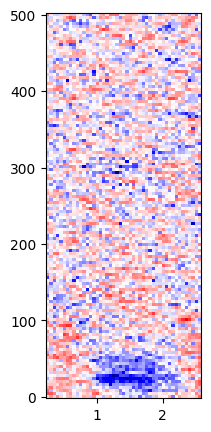

In [111]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (2, 5))

ax = plt.gca()

ax.pcolormesh(
    sxx_data_dict['t'][:47],
    sxx_data_dict['f'],
    mean_sxx_direction[:,:,18],
    # norm=mpl.colors.PowerNorm(gamma=1.0 / 0.3),
    cmap="seismic",
    vmin=-3, 
    vmax=3
#     cmap="YlGnBu"
)

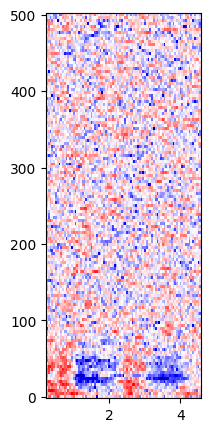

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (2, 5))

ax = plt.gca()

ax.pcolormesh(
    sxx_data_dict['t'][:87],
    sxx_data_dict['f'],
    mean_sxx_direction[:,:,18],
    # norm=mpl.colors.PowerNorm(gamma=1.0 / 0.3),
    cmap="seismic",
    vmin=-3, 
    vmax=3
#     cmap="YlGnBu"
)


In [9]:
sxx_data_dict.keys()

dict_keys(['f', 't', 'sxx', 'sampling_rate'])

In [5]:
data = list(data_dict.values())[0]()

('/home/sshah/CortiCom/decoding-pipeline/data/01_raw/CC01/ccCenterOut/ccCenterOut_20221027_S03.hdf5',)
{}


In [6]:
aux = data.group.aux()

In [20]:
x = aux[2000:, ['cursorX']]
y = aux[2000:, ['cursorY']]

[<matplotlib.lines.Line2D object at 0x7f9ea00ae8f0>]

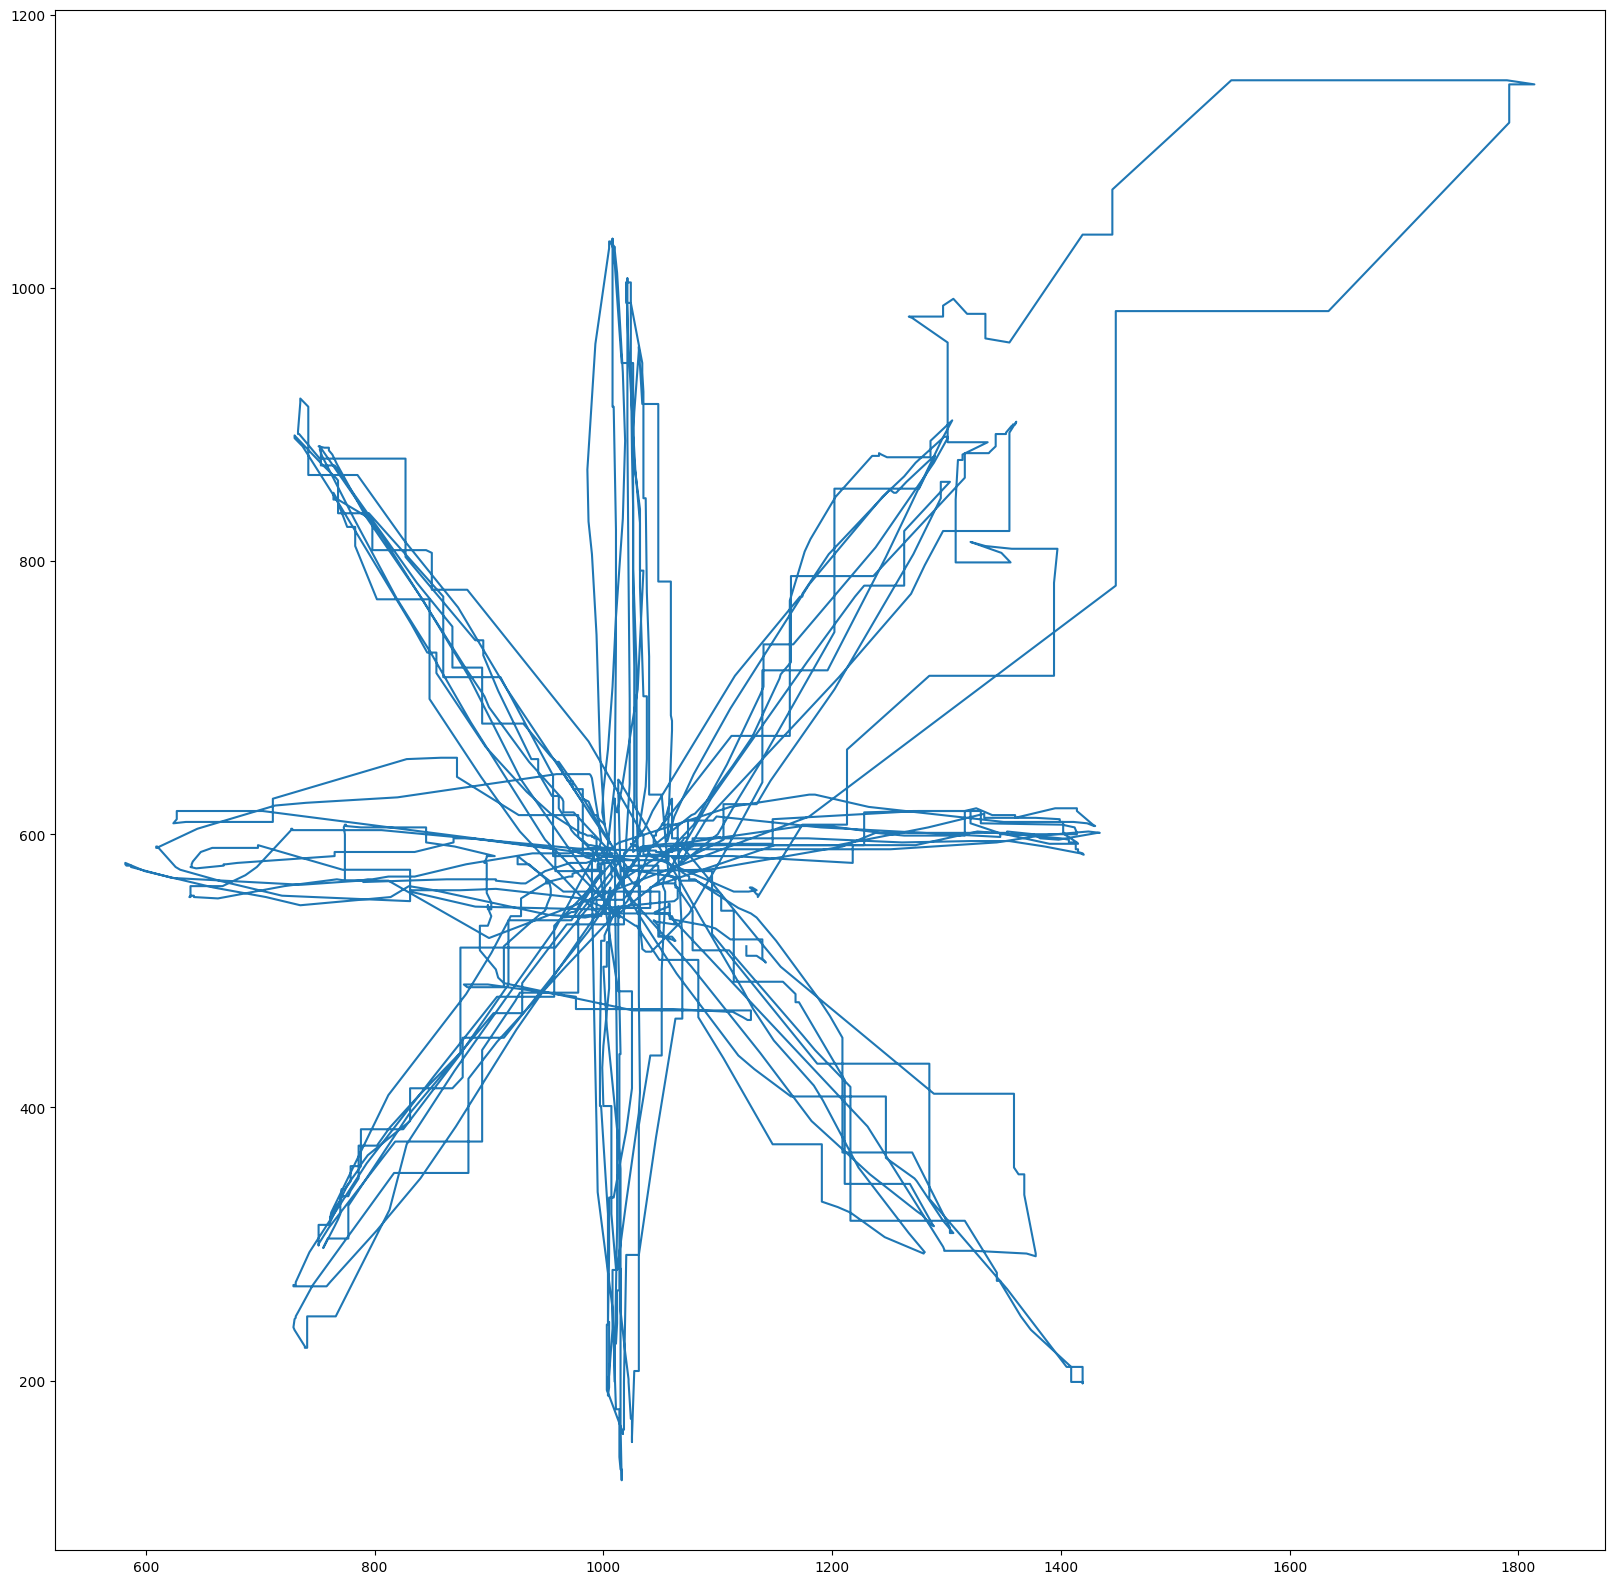

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.plot(x, y)

In [19]:
print(x.flatten()[2000:3000])

[1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024
 1024 